In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -P datasets

--2020-04-27 00:37:23--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘datasets/cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  51.2MB/s    in 3.5s    

2020-04-27 00:37:27 (46.0 MB/s) - ‘datasets/cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [3]:
!ls datasets/

cifar10  cifar-10-batches-py  cifar-10-python.tar.gz  cifar-10-python.tar.gz.1


In [0]:
!tar xf datasets/cifar-10-python.tar.gz -C datasets/

In [5]:
!ls datasets

cifar10  cifar-10-batches-py  cifar-10-python.tar.gz  cifar-10-python.tar.gz.1


In [0]:
with open('datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file:
  X = pickle.load(input_file, encoding='latin1')

In [0]:
X = X['data']

In [8]:
X.shape

(10000, 3072)

In [9]:
X = X.reshape((-1, 3, 32, 32))
X.shape

(10000, 3, 32, 32)

In [10]:
# batch_size, channel, height, width --> batch_size, height, width, channels
X = X.transpose(0, 2, 3, 1)
X.shape

(10000, 32, 32, 3)

In [11]:
# To go back to original
X = X.reshape(-1, 3*32*32)
X.shape

(10000, 3072)

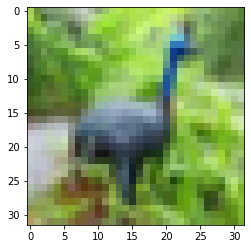

In [12]:
plt.imshow(X[6].reshape(32, 32, 3))
plt.show()

In [0]:
X = X - X.mean(axis=0)

In [0]:
X = X / np.std(X, axis= 0)

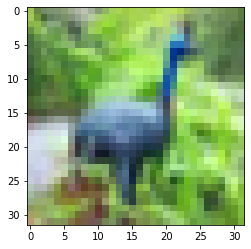

In [15]:
def show(i):
  i = i.reshape((32, 32, 3))

  m, M = i.min(), i.max()

  plt.imshow((i - m)/ (M - m))
  plt.show()

show(X[6])

In [16]:
# Whitening
X_subset = X[:1000]

X_subset.shape

(1000, 3072)

In [0]:
cov = np.cov(X_subset, rowvar=True)

In [18]:
cov.shape

(1000, 1000)

In [0]:
U, S, V = np.linalg.svd(cov)

In [20]:
print(U.shape)
print(S.shape)
print(V.shape)

(1000, 1000)
(1000,)
(1000, 1000)


In [0]:
epsilon = 1e-5

In [0]:
zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

In [23]:
zca_matrix.shape

(1000, 1000)

In [0]:
zca = np.dot(zca_matrix, X_subset)

In [25]:
zca.shape

(1000, 3072)

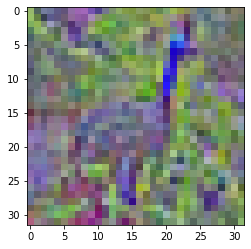

In [26]:
show(zca[6])

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [0]:
transform = transforms.Compose([
                          transforms.Resize(256),
                          transforms.ToTensor()                   
])

In [30]:
dataset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', download=True, transform=transform)

Files already downloaded and verified


In [31]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [0]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=2)

In [0]:
images_batch, labels_batch = iter(dataloader).next()

In [34]:
images_batch.shape

torch.Size([16, 3, 256, 256])

In [35]:
labels_batch.shape

torch.Size([16])

In [36]:
labels_batch

tensor([2, 4, 5, 4, 2, 6, 9, 8, 3, 1, 1, 0, 7, 3, 6, 6])

In [0]:
img = torchvision.utils.make_grid(images_batch)

In [38]:
img.shape

torch.Size([3, 518, 2066])

In [0]:
img = np.transpose(img, (1,2,0))

In [40]:
img.shape

torch.Size([518, 2066, 3])

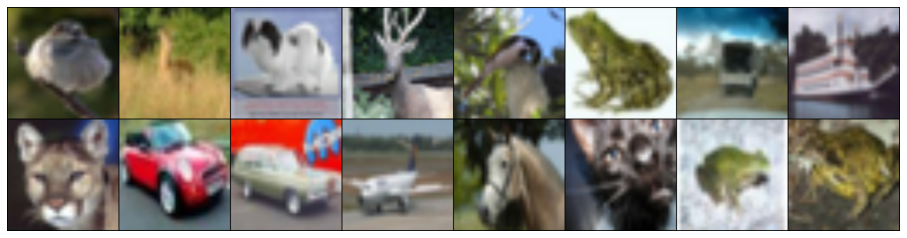

In [41]:
plt.figure(figsize=(16,32))
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:
# You can't load the entire dataset at once
pop_mean = []
pop_std = []

In [0]:
for i, data in enumerate(dataloader, 0):
  numpy_image = data[0].numpy()

  batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
  batch_std = np.std(numpy_image, axis=(0, 2, 3))

  pop_mean.append(batch_mean)
  pop_std.append(batch_std)

In [0]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

In [45]:
pop_mean.shape, pop_std.shape

((3125, 3), (3125, 3))

In [0]:
pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [47]:
pop_mean, pop_std

(array([0.4915909 , 0.48234633, 0.44672012], dtype=float32),
 array([0.23829688, 0.23484518, 0.2526138 ], dtype=float32))

In [0]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.ColorJitter(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(pop_mean, pop_std)
                              ])

In [49]:
trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8)

In [0]:
images_batch, labels_batch = iter(trainloader).next()

In [52]:
images_batch.shape

torch.Size([16, 3, 224, 224])

In [53]:
img = torchvision.utils.make_grid(images_batch)

img.shape

torch.Size([3, 454, 1810])

In [54]:
img = np.transpose(img, (1, 2, 0))

img.shape

torch.Size([454, 1810, 3])

In [55]:
m, M = img.min(), img.max()
m, M

(tensor(-2.0539), tensor(2.2042))

In [0]:
img = (1/(abs(m) - M)) * img + .5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


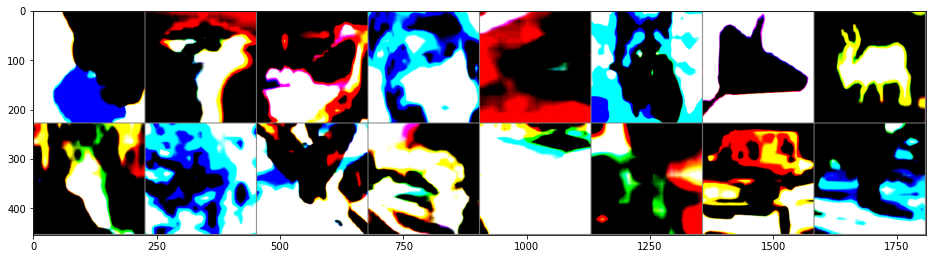

In [57]:
plt.figure(figsize=(16,12))

plt.imshow(img)
plt.show()